# K-class logistic regression with Polya-Gamma augmentation

In [1]:
using LinearAlgebra
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/BUT/Repositories/myForks/BayesianModels/Project.toml`
┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/landini/.julia/packages/Revise/XFtoQ/src/Revise.jl:1306
┌ Info: Precompiling BayesianModels [56ff943f-52c4-4398-bcf1-974dffc1fcd6]
└ @ Base loading.jl:1260


### Synthetic data

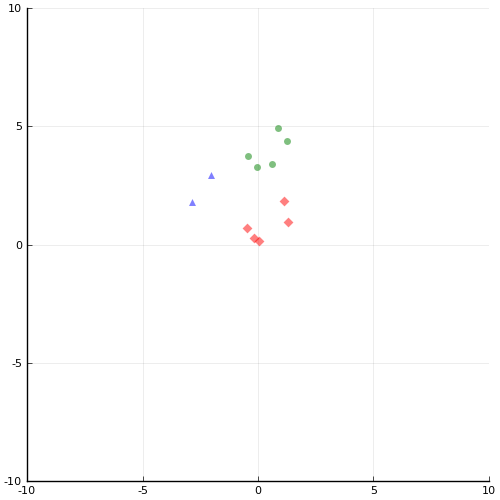

In [70]:
# Class 1
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]

# Class 2
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]
μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

# Class 3
μ4 = [-3, 3]
Σ4 = .5 * [1. 0.; 0. 1.]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 1

x1 = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2 = samplenormal(μ3, Σ3, 5  * sizecoeff)
x3 = samplenormal(μ4, Σ4, 2  * sizecoeff)

# x1 = randn(2, 2 * sizecoeff) .- 5
# x2 = randn(2, 2 * sizecoeff)  
# x3 = randn(2, 2 * sizecoeff) .+ 5

X = hcat(x1, x2, x3)
z = vcat(ones(Int64, size(x1, 2)), ones(Int64, size(x2, 2)) * 2,  
         ones(Int64, size(x3, 2)) * 3)


function plotdata!(p, x1, x2, x3)
    scatter!(p, x1[1, :], x1[2, :], label=nothing, marker = (:diamond, 5, 0.5, :red, stroke(0)))
    scatter!(p, x2[1, :], x2[2, :], label=nothing, marker = (:circle, 5, 0.5, :green, stroke(0)))
    scatter!(p, x3[1, :], x3[2, :], label=nothing, marker = (:utriangle, 5, 0.5, :blue, stroke(0)))
end

p = plot(size=(500, 500), xlims=(-10, 10), ylims=(-10, 10))
plotdata!(p, x1, x2, x3)

### Model initialization

In [71]:
model = LogisticRegression(inputdim = 2, nclasses = 3, pseudocounts = 1, hasbias = true)

LogisticRegression{3}(
  (stickbreaking): [
    (1) BinaryLogisticRegression(
      (β): ConjugateParameter{Normal{Float64,3}}
    )
    (2) BinaryLogisticRegression(
      (β): ConjugateParameter{Normal{Float64,3}}
    )
  ]
)


### Training

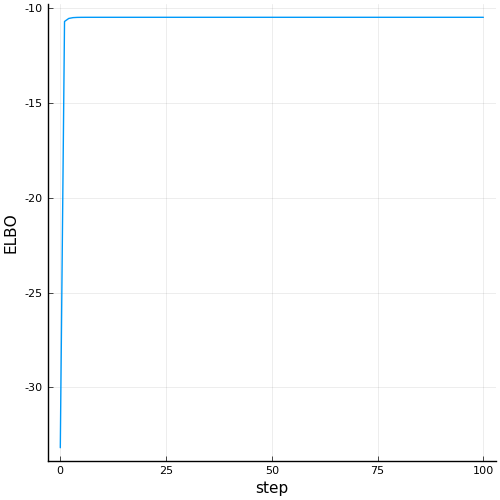

In [72]:
# Number of training step. One step will update both the β and ω parameter.
nsteps = 100
elbos = [elbo(model, X, z)]

for step in 1:nsteps    
    for param in getconjugateparams(model)
        stats = (X, z) |> param.stats
        accstats = dropdims(sum(stats, dims = 2), dims=2)
        update!(param.posterior, naturalparam(param.prior) + accstats)
    end
    
    # This is just for monitoring, not actually needed for training.
    push!(elbos, elbo(model, X, z))   
end

ptraining = plot(
    0:nsteps, elbos,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

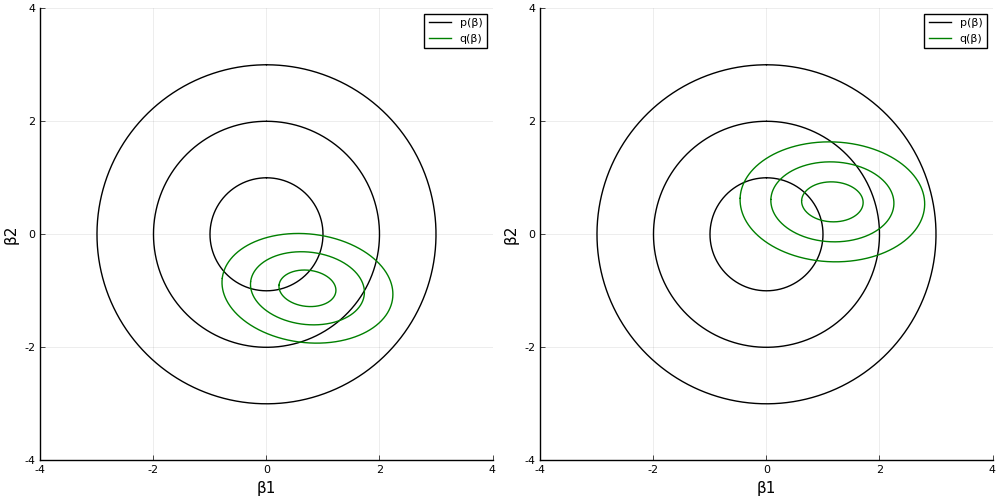

In [73]:
l = @layout [a b]
ppost1 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")

μ₀ = model.stickbreaking[1].β.prior.μ
Σ₀ = model.stickbreaking[1].β.prior.Σ
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ
plotnormal2d(ppost1, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 3, color = :black, label="p(β)")
plotnormal2d(ppost1, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :green, label="q(β)")

ppost2 = plot(xlims = (-4, 4), ylims = (-4, 4),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
μ₀ = model.stickbreaking[2].β.prior.μ
Σ₀ = model.stickbreaking[2].β.prior.Σ
μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ
plotnormal2d(ppost2, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 3, color = :black, label="p(β)")
plotnormal2d(ppost2, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :green, label="q(β)")


plot(ppost1, ppost2, layout = l, size = (1000, 500))

### Visualisation

In [74]:
function sampleβ(μ, Σ)
    L = cholesky(Σ).L
    μ .+ L * randn(length(μ))
end

function plotdecisionline!(p, w, w₀; plotting_radius=20, args...)
    # Normalize vector of weights
    norm_w = w ./ sqrt(sum(w.^2))

    # Angle of the weight vector in the range [0,2 π]
    θ = atan(w[2], w[1]) + π

    # Vector perpendicular to "w" with unit length.
    w⊥ = [cos(θ + π/2), sin(θ + π/2)]

    # Translation vector of  the decision boundary induced
    # by the bias
    shift = -(w₀ / sqrt(sum(w.^2))) * norm_w

    # Angle of the decision line in the range [0, 2π]
    α = atan(w⊥[2], w⊥[1]) + π
    
    # To get the decision line we rotate and shift the 
    # abscissa
    R = [cos(α) -sin(α); sin(α) cos(α)]
    decisionline = vcat(range(-plotting_radius, plotting_radius, length=1000)', zeros(1000)') 
    decisionline = R * decisionline .+ shift
    
    plot!(p, decisionline[1, :], decisionline[2, :]; args...)
end

plotdecisionline! (generic function with 1 method)

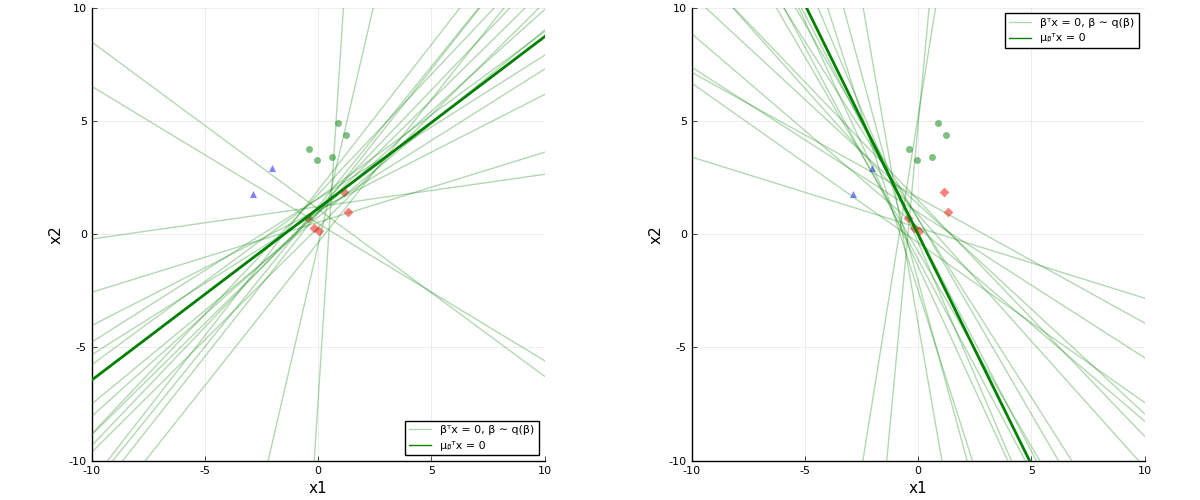

In [75]:
μᵦ = model.stickbreaking[1].β.posterior.μ
Σᵦ = model.stickbreaking[1].β.posterior.Σ

pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-10, 10),
    ylims=(-10, 10),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1, x2, x3)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.stickbreaking[1].hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.stickbreaking[1].hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec1, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")


###################################################

μᵦ = model.stickbreaking[2].β.posterior.μ
Σᵦ = model.stickbreaking[2].β.posterior.Σ

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-10, 10),
    ylims=(-10, 10),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1, x2, x3)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.stickbreaking[2].hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.stickbreaking[2].hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec2, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))

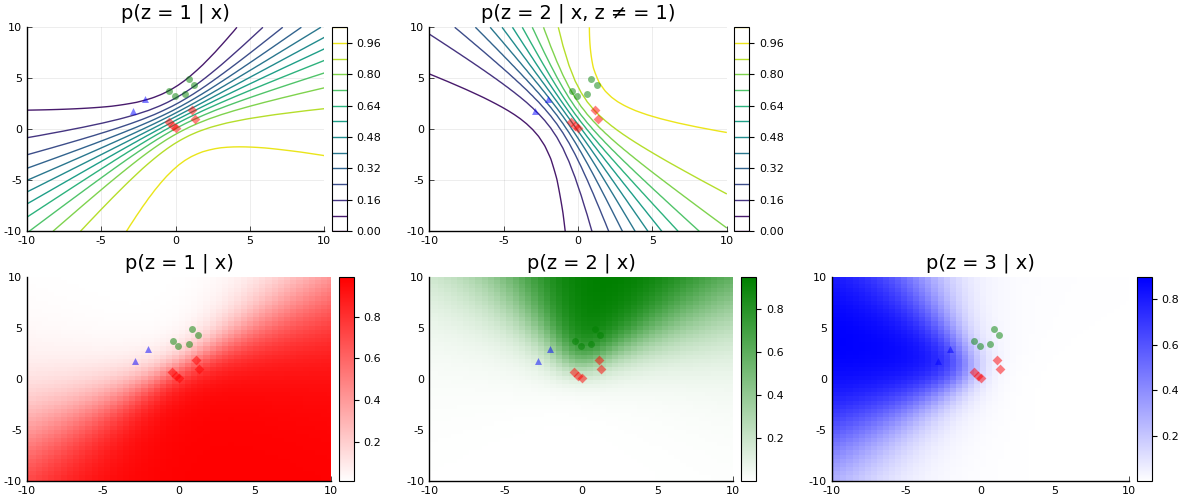

In [76]:
# Resolution for plotting the decision region
res = 50

# Generate a grid of the input space
dim1 = range(-10, 10, length=res)
dim2 = range(-10, 10, length=res)
testX = vec([ [i, j] for i=dim1, j=dim2])
testX = hcat(testX...)

# Prediction of the model in a KxN array
pz = reshape(predict(model, testX), :, res, res)

# Prediction of the stick-breaking process (just for plotting not used in practice)
pz1 = reshape(predict(model.stickbreaking[1], testX), res, res)
pz2_z1 = reshape(predict(model.stickbreaking[2], testX), res, res)

#################################
# Plotting p(z = 1 | x)

ppredict1 = heatmap(
    title = "p(z = 1 | x)",
    dim1, 
    dim2,
    pz[1, :, :]',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = cgrad([:white, :red])
)
plotdata!(ppredict1, x1, x2, x3)


ppredict1_1 = plot(
    title = "p(z = 1 | x)",
    dim1, 
    dim2,
    pz1',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = :viridis
)
plotdata!(ppredict1_1, x1, x2, x3)

#################################
# Plotting p(z = 3 | x) and p(z = 2 | x, z ≠ 1)

ppredict2 = heatmap(
    title = "p(z = 2 | x)",
    dim1, 
    dim2,
    pz[2, :, :]',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = cgrad([:white, :green])
)
plotdata!(ppredict2, x1, x2, x3)

ppredict2_1 = plot(
    title = "p(z = 2 | x, z ≠ = 1)",
    dim1, 
    dim2,
    pz2_z1',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = :viridis
)
plotdata!(ppredict2_1, x1, x2, x3)

#################################
# Plotting p(z = 3 | x)

ppredict3 = heatmap(
    title = "p(z = 3 | x)",
    dim1, 
    dim2,
    pz[3, :, :]',
    xlims = (-10, 10),
    ylims = (-10, 10),
    #c = :viridis
    c = cgrad([:white, :blue])
)
plotdata!(ppredict3, x1, x2, x3)


ppredict3_12 = plot(legend=false,grid=false,foreground_color_subplot=:white)  # create subplot to be blank

l = @layout [a b c; d e f]
plot(ppredict1_1, ppredict2_1, ppredict3_12, ppredict1, ppredict2, ppredict3, layout = l, size = (1200, 500))

In [77]:
ψ1 = -3 # we want this to be ψ1 = β' * X (X is the data already defined above)
ψ2 = -3
function σ(ψ)
    1 / (1+exp(-ψ))
end
ν1 = σ(ψ1)
ν2 = σ(ψ2)

println("ν1=$ν1, ν2=$ν2, π1=$ν1, π2=$(ν2*(1-ν1)), π3=$(1*(1-ν1)*(1-ν2)))")

ν1=0.04742587317756678, ν2=0.04742587317756678, π1=0.04742587317756678, π2=0.04517665973091214, π3=0.9073974670915211)


In [78]:
function encode(z, n_classes)
    # For the purpose of operating with matrices the function encodes the vector of classes as:
    # onehot: one-hot encoding for the classes, where the class 'n_classes' is encoded as all 0's
    # N_up_to: for each sample of class c, row i is 1 if i>=c and 0 otherwise. Note that if c=n_classes, all rows are 0's
    
    onehot = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        onehot[i, z .== i] .= 1
    end

    N_up_to = zeros(Int64, n_classes - 1, length(z))
    for i = 1:n_classes-1
        N_up_to[i, z .> i] .= 1
    end

    onehot, N_up_to
end

function loglikelihood(z, ν1, ν2)
    onehot, N_up_to = encode(z, 3)
    #print("onehot=$onehot \n")
    #print("N_up_to=$N_up_to \n")
    logParams = [log(ν1), log(ν2)]
    logComplementParams = [log(1-ν1), log(1-ν2)]
    onehot' * logParams .+ N_up_to' * logComplementParams
    #print("$(onehot' * logParams)\n $(N_up_to' * logComplementParams) \n")
end


loglikelihood(z, ν1, ν2)

12-element Array{Float64,1}:
 -3.048587351573742
 -3.048587351573742
 -3.048587351573742
 -3.048587351573742
 -3.048587351573742
 -3.097174703147484
 -3.097174703147484
 -3.097174703147484
 -3.097174703147484
 -3.097174703147484
 -0.09717470314748404
 -0.09717470314748404

In [85]:
# Using Logistic Regression

function deriv_sig(β, x)
    (1 .- σ.(β*x)) * x'
end


function deriv_comp_sig(β, x)
    .- σ.(β*x) * x'
end


function loglikelihood(n_classes, z, ν)
    onehot, N_up_to = encode(z, n_classes)
    logParams = log.(ν)
    logComplementParams = log.(1 .- ν)
    sum(diag(onehot' * logParams .+ N_up_to' * logComplementParams))
end


function loglikelihood_all(n_classes, z, X, β)
    ν = σ.(β*X)
    loglikelihood(n_classes, z, ν)
end

n_classes = 3
β = zeros(Float64, n_classes-1, size(X, 1)+1) # +1 to account for the bias

X_augmented = [X; ones(Float64, 1, size(X, 2))] # add 1's to account for the bias

onehot, N_up_to = encode(z, n_classes)
η = 0.01

# Contains terms of derivative corresponding to log(σ(β'x_d)) for data point x_d
deriv_sig_for_all = zeros(size(β, 1), size(X_augmented, 2), size(X_augmented, 1))
# Contains terms of derivative corresponding to log(1 - σ(β'x_d)) for data point x_d
deriv_comp_sig_for_all = zeros(size(β, 1), size(X_augmented, 2), size(X_augmented, 1))

print("step 0, loglikelihood: $(loglikelihood_all(n_classes, z, X_augmented, β))\n")


for step = 1:1000
    # Populate for all data points
    for d = 1:size(deriv_sig_for_all, 2)
        deriv_sig_for_all[:, d, :] = deriv_sig(β, X_augmented[:,d])
        deriv_comp_sig_for_all[:, d, :] = deriv_comp_sig(β, X_augmented[:,d])
    end
    # Update parameters
    derivatives = sum(onehot .* deriv_sig_for_all .+ N_up_to .* deriv_comp_sig_for_all, dims=2)[:,1,:]
    β = β + η * derivatives
    
    # Show progress
    if step % 100 == 0
        print("step $(step), loglikelihood: $(loglikelihood_all(n_classes, z, X_augmented, β))\n")
    end
end



step 0, loglikelihood: -13.16979643063896
step 100, loglikelihood: -3.1889035444716445
step 200, loglikelihood: -1.973811376465783
step 300, loglikelihood: -1.4373930968029676
step 400, loglikelihood: -1.1348765507017613
step 500, loglikelihood: -0.9402718401133693
step 600, loglikelihood: -0.8042989629479711
step 700, loglikelihood: -0.7037533676749224
step 800, loglikelihood: -0.6262745694938
step 900, loglikelihood: -0.5646702927351246
step 1000, loglikelihood: -0.5144677600082846


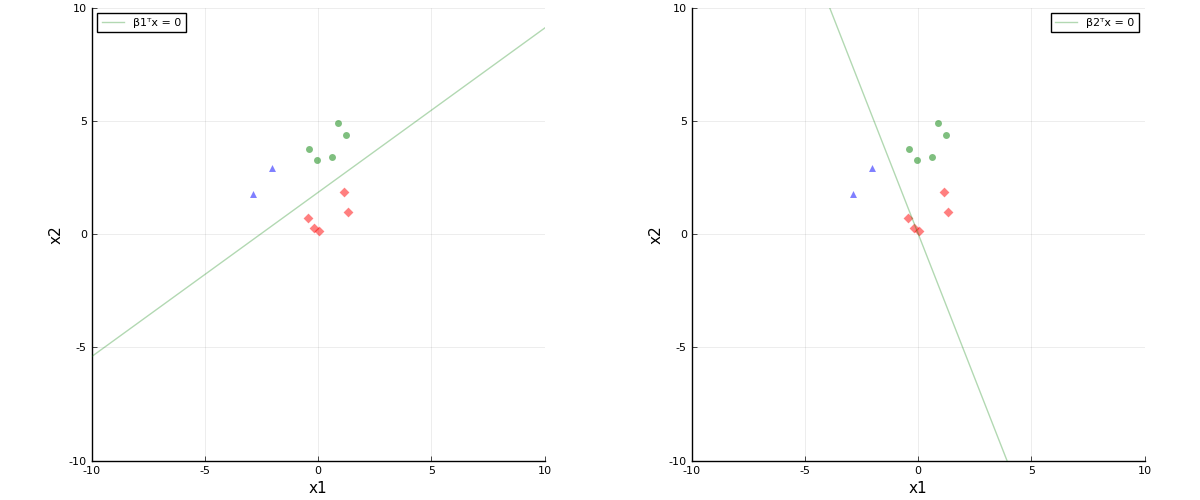

In [86]:
pdec1 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-10, 10),
    ylims=(-10, 10),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec1, x1, x2, x3)

w = β[1, 1:size(X,1)]
w₀ = β[1, size(X,1)+1]

label = "β1ᵀx = 0" 
plotdecisionline!(pdec1, w, w₀, line = (:green, 0.3), label=label)


###################################################

pdec2 = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-10, 10),
    ylims=(-10, 10),
    xlabel="x1", 
    ylabel="x2"
)

plotdata!(pdec2, x1, x2, x3)

w = β[2, 1:size(X,1)]
w₀ = β[2, size(X,1)+1] 
    
label = "β2ᵀx = 0" 
plotdecisionline!(pdec2, w, w₀, line = (:green, 0.3), label=label)


###################################################

l = @layout [a b]
plot(pdec1, pdec2, layout = l, size = (1200, 500))